In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


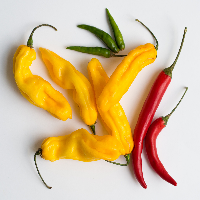

In [4]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/cloud dataset/chilli pepper/Image_10.jpg')
img_resized = cv2.resize(img, (200,200)) # SMALL DISTORTION are WELCOME! 
cv2_imshow(img_resized)

In [5]:
img_resized[0] # EACH element is a LIST of 3 elements -> CHANNEL value-> 3 channels
img_resized.shape

(200, 200, 3)

In [6]:
img_resized[5][0]

array([227, 224, 220], dtype=uint8)

In [7]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
from keras import backend # backend -> tf/theano etc
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential

2.9.2


In [8]:
class PandaVGG:
  @staticmethod
  def build( height, width, depth, classes) :
  
    # let's assume we are on TF, else we will switch to Theano 
    inputShape = (height, width, depth)
    channel_dim = -1  # last element -> CHANNELS_LAST 
    if backend.image_data_format() == 'channels_first':
      inputShape = (depth, height, width)
      channel_dim = 1
    # { data, representation } => [data,representation] or [representation, data]
    #  { images, channels}     => channels_last or channels_first 
    # data -> 2 d images -> height [row], width [columns] 

    HP_block1_conv_dim = 32    
    HP_small_pattern = (3,3)
    HP_block2_conv_dim = 64
    HP_block3_conv_dim = 128
    HP_block4_conv_dim = 256
    HP_block5_dense_dim = 1024
    HP_large_pattern = (2,2)
    HP_dropout_type1 = 0.25
    HP_dropout_type2 = 0.50
    
    model = Sequential()
# PandaVGG = (Conv + ReLU + BN) + MP + Dropout + ((Conv + ReLU + BN)X2 + MP + Dropout) X N
#             + (Flatten + Dense(ReLu) + Dense(SoftMax))

    # block1 starts-> (Conv + ReLU + BN) + MP + Dropout 
    model.add(Conv2D(HP_block1_conv_dim, HP_small_pattern, padding='same', input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim)) # our data needs to be normalized, not our channels!!!
    model.add(MaxPooling2D(pool_size=HP_small_pattern))
    model.add(Dropout(HP_dropout_type1))
    # block1 complete 

    #block2 starts -> (Conv + RelU + BN) X2   + Compress + Drop 
    model.add(Conv2D(HP_block2_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(HP_block2_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_large_pattern))
    model.add(Dropout(HP_dropout_type1))
     # BLock 2 ends 

    #Block3 starts
    model.add(Conv2D(HP_block3_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(HP_block3_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_large_pattern))
    model.add(Dropout(HP_dropout_type1))
    # block3 ends

    #Block4 starts
    model.add(Conv2D(HP_block4_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(HP_block4_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_large_pattern))
    model.add(Dropout(HP_dropout_type1))
    # block4 ends

    # final block5- classification/prediction
    model.add(Flatten())
    model.add(Dense(HP_block5_dense_dim))
    model.add(Activation('relu'))
    # optional: Batch Normalization and Dropout -> to avoid overfitting 
    model.add(BatchNormalization())
    model.add(Dropout(HP_dropout_type2))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    # final block ends

    return model

In [9]:

 # minimum image sizes that NN can clearly identify
# black & white images                          -> 28X28 
# multi-channels images (3 channels in our case)-> 96X96 (3 X (32,32)) 

model = PandaVGG.build(96, 96, 3, 3)
model.summary() 

# 32 filters -> each filter is 3X3 -> PER CHANNEL
# 1 filter = [ [w11,w12,w13],[w21,w22,w23],[w31,w32,w33]] -> 9 weights 
# 32 X 9 = 288 -> 1 channel

# 288 X 3 = 864 weights
# 32 filters generated, each with 1 bias
# weights + bias = 864 + 32 = 896

# EXPORT the built model -> right approach 
# next file-> train.py -> import the model 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
from sklearn.preprocessing import LabelBinarizer # Label encoding, 1-hot encoding, multi-encoding
# LABEL binarizer is a 1-hot encoded MATRIX 
import cv2
import numpy as np
import random
import imutils
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split

In [15]:
# if this was a User Facing software or web/mobile app, we would have been using a UI
HP_dataset = '/content/drive/MyDrive/cloud dataset'
HP_model_path = '/content/drive/MyDrive/bin/model/myModel.h5'
HP_binarized_labels = '/content/drive/MyDrive/bin/labels/labels.bin'
HP_metrics_storage = 'eval'
HP_test_dataset = 'test'
HP_epoch = 100
HP_init_lr = 1e-3 # learning_rate = 0.001
HP_batch_size = 32
HP_image_dim = (96,96,3)

In [16]:
data = []
labels = [] 
# read all images
all_images = sorted(list(paths.list_images(HP_dataset)))
print (len(all_images))
all_images[:1]

381


['/content/drive/MyDrive/cloud dataset/apple/1000_F_176979696_hqfioFYq7pX13dmiu9ENrpsHZy1yM3Dt.jpg']

In [17]:
random.seed(42)
random.shuffle(all_images)
all_images[:10]
print(len(all_images))

381


In [18]:
import os
for impath in all_images:
  img = cv2.imread(impath)
  resized = cv2.resize(img, (HP_image_dim[0],HP_image_dim[1]) )
  imageData = img_to_array(resized)
  data.append(imageData)
  # extract label from filename (2nd last element) / \ 
  label = impath.split(os.path.sep)[-2]
  labels.append(label)

print(len(labels))
#print(data[0])
# X and Y -> data and labels 

381


In [21]:
# CONVERT labels to MATRICES -> if input is matrix, output should be MATRIX!
# data[element] -> Array of arrays 
labels = np.array(labels)
lb = LabelBinarizer()
binarized_labels = lb.fit_transform(labels)
print(binarized_labels[0])
print(binarized_labels[1])
print(len(binarized_labels))

# 1-hot encoding v/s          Label Binarizing 
# Inputs                      Labels (outputs)
# creates new columns         creates 1-hot encoding in same element 
#                             [ [dog] , [pikachu], [shaktiman]]
#                             4 -> 1 0 0  -> number's binary rep is used to gen Binarizers 


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
381


In [22]:
binarized_labels[0].dtype

dtype('int64')

In [23]:
norm_data = np.array(data, dtype='float') / 255
trainx, testx, trainy, testy = train_test_split(norm_data,binarized_labels,test_size=0.2)
# train and test data ready 
# Augmentation generators are logic for augmentation
# APplication of augmentation is after this

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')


# mathematical ops -> new_data = old_data * sin(7)

# Regularization -> L1/L2 (ridge/lasso), Dropout, early stopping ,data augmentation 
# whenever working with images, we don;t want our model to overfit
# FACE -> face directly looking at me
# FACE -> 30 degrees to right, and still looking at me, we should be able to recognize it 
# as well!

# we will generate ALL possible MUTATION/TRANSFORMATIONS of our images 

# data_cleaning.py ends here
     

In [24]:
print(len(trainx))
print(len(trainy))

print(len(testx))
print(len(testy))

304
304
77
77


In [25]:
# previous class is also correct, use any
class CorrectPandaVGG: # model.fit(), model.predict() ; for them you need object
  @staticmethod
  def create(width, height, depth, classes): # TF was CHANNELS_LAST -> depth is mentioned as the last value, after w&h
    model = Sequential()
    inputShape = (height, width, depth) # the expected shape as per TF
    # but what if this program is then run on some other framework? which follows channels_first instead?
    chanDim = -1 # CHANNELS_LAST set as default 
    # now check if some other library except TF or CNTK is running
    if backend.image_data_format() == "channels_first":
      inputShape = (depth, height, width) # this chan_dim is a measure of DEPTH of data-> so makes sense only for multidimension data, such as image or video
      chanDim = 1 # for Theano (if tf or CNTK is not running)
    # Design our network
    # FIRST BLOCK = Conv + ReLU + BN + MP + D
    model.add(Conv2D(32,(3,3), padding='same', input_shape=inputShape)) # all keras backends compatible
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim)) # Normalization needs to be along axis- R,G and B! 
    # After BN, the important FILTERED features are available now as WEIGHTS 
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25)) 
    # Learning Layers -> Conv + ReLU + BN
    # that means, to increase the number of features, i need to repeat the Conv+ReLU+BN to generate more and more
    # features
    # MAX Pool is to compress, and Dropout -> randomly select features for partial learning 
    
    # BLOCK 2 should have slightly more features, because we have compressed and DROPPED the data!!! 
    # we should generate more activity maps henceforth to compensate for data loss 
    # BLOCK 2 = (Conv->Relu->BN)X2 + MP + D
    # LET X = Conv->Relu->BN
    # Block 2 = 2 X + MP + D
    # My network so far = Block 1 + Block 2
    # FeatureClassification = Flatten + Dense(ReLU) + Dense(SoftMax)
    # PandaVGG = X + MP + D +   ( 2 X + MP + D ) * no_of_times_you_want_to_repeat + FeatureClassification
    # First X -> got activity map for 100% of data (X=Conv+Relu+BN)
    # then Activity Maps are compressed and sent to subsequent layers (MaxPooling)
    # Dropout to learn about only a section of data (Dropout)
    model.add(Conv2D(64,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2))) # SMALLER pool size-> finer features selected -> BIGGER compression
    model.add(Dropout(0.25))

    # block 3
    model.add(Conv2D(128,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2))) # SMALLER pool size-> more data lost -> BIGGER compression
    model.add(Dropout(0.25))
    # block 4
    model.add(Conv2D(256,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(256,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2))) # SMALLER pool size-> more data lost -> BIGGER compression
    model.add(Dropout(0.25))
    #VGG has now become = block1 +block2+block3+block4 + FeatureClassification
    # VGG= X(32)+MP(3,3)+D+2X(64)+MP(2,2)+D+2X(128)+MP(2,2)+D+2X(256)+MP(2,2)+D+Flatten+DenseRelu+DenseSoftMax
    # Where X = Conv2D + ReLU + BN 
    # Our PandaVGG now has 32 layers

    #FINAL Classification block
    # ALL micro and macro features (FILTERsX Input = Activity Map) have been generated
    # SO FLATTEN out to bring all axises into same DIMENSION
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    # optional: EVEN more regularization
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    #regularization over, Classify using SOFTMAX
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    return model 

In [26]:
# TRAIN.py should start! 

from keras.optimizers import Adam
# or use the previous class, both are same
model = CorrectPandaVGG.create(HP_image_dim[0], HP_image_dim[1], HP_image_dim[2],len(lb.classes_))
optimizer = Adam(lr=HP_init_lr, decay= HP_init_lr/HP_epoch)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])



# 1image = 10% shaktiman, 50% pikachu, 40% doggie (categorical_cross)
# 1image = 0.3% shaktiman, 99.5% pikachu, 0.2% doggie (sparse_categorical_cross)

# binary_crossentropy, sparse_categorical_crossentropy -> image classification
# categorical_crossentropy -> object detection

# DECAY -> when training is over, we want LR to be 0! 
# LR -> 0 means that perfect answer is reached 
# ADAPTIVE LEARNING-> inc lr if far from ans, dec if closer to
# inc/dec -> decay rate 

# v= u + at
# final_velocity = init_velocity + acceleration * time  
# final_lr = init_lr + decay*epoch
# 0 = 0.001 + decay_rate * epoch
# decay_rate =  - init_lr / epoch # minus anyway indicates deacceleration 


# SPARSE_categorical_crossentropy -> SPARSE will ensure that only 1 prob was highest
# categorical_crossentropy  -> just prob distribution -> multiple classes could have
# nearby probailities! MULTIPLE CLASSES could have been detected in 1 image!!!
# if an image has both Shaktiman and Pikachu-> we will be able to get some probab_dist for both



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
history = model.fit_generator(aug.flow(trainx, trainy, batch_size=HP_batch_size), validation_data=(testx,testy),steps_per_epoch = len(trainx)// HP_batch_size,epochs=50)
     

<ipython-input-27-645f46a4c75c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(aug.flow(trainx, trainy, batch_size=HP_batch_size), validation_data=(testx,testy),steps_per_epoch = len(trainx)// HP_batch_size,epochs=50)


Epoch 1/50
9/9 [==============================] - 14s 1s/step - loss: 9.7284 - accuracy: 0.0903 - val_loss: 3.5873 - val_accuracy: 0.0260
Epoch 2/50
9/9 [==============================] - 12s 1s/step - loss: 5.0644 - accuracy: 0.1324 - val_loss: 3.6502 - val_accuracy: 0.0519
Epoch 3/50
9/9 [==============================] - 12s 1s/step - loss: 3.1584 - accuracy: 0.2757 - val_loss: 4.1584 - val_accuracy: 0.0130
Epoch 4/50
9/9 [==============================] - 12s 1s/step - loss: 2.8629 - accuracy: 0.2684 - val_loss: 4.7657 - val_accuracy: 0.0519
Epoch 5/50
9/9 [==============================] - 12s 1s/step - loss: 2.4693 - accuracy: 0.3824 - val_loss: 5.4905 - val_accuracy: 0.0390
Epoch 6/50
9/9 [==============================] - 12s 1s/step - loss: 2.1000 - accuracy: 0.4653 - val_loss: 5.2793 - val_accuracy: 0.0649
Epoch 7/50
9/9 [==============================] - 12s 1s/step - loss: 1.8629 - accuracy: 0.5000 - val_loss: 5.4121 - val_accuracy: 0.0390
Epoch 8/50
9/9 [==================

In [28]:
import pickle
HP_model_path ='/content/drive/MyDrive/bin/model/myModel.h5'
HP_binarized_labels = '/content/drive/MyDrive/bin/labels/labels.bin'
model.save(HP_model_path)
f = open(HP_binarized_labels, 'wb') # our integer is represent in binary format!
f.write(pickle.dumps(lb))
f.close()
print(lb.classes_)

['apple' 'banana' 'beetroot' 'bell pepper' 'cabbage' 'capsicum' 'carrot'
 'cauliflower' 'chilli pepper' 'corn' 'cucumber' 'eggplant' 'garlic'
 'ginger' 'grapes' 'jalepeno' 'kiwi' 'lemon' 'lettuce' 'mango' 'onion'
 'orange' 'paprika' 'pear' 'peas' 'pineapple' 'pomegranate' 'potato'
 'raddish' 'soy beans' 'spinach' 'sweetcorn' 'sweetpotato' 'tomato'
 'turnip' 'watermelon']


In [44]:
import pickle
import numpy as np
import imutils
import cv2
import os
from keras_preprocessing.image import img_to_array
from keras.models import load_model 

# Load the model and binarized labels
HP_model_path = '/content/drive/MyDrive/bin/model/myModel.h5'
HP_binarized_labels = '/content/drive/MyDrive/bin/labels/labels.bin'
# assume model is already loaded in model variable
f = open(HP_binarized_labels, 'rb')
mylabels = f.read()
binarized_labels = pickle.loads(mylabels)

# model.load() should be written
# model.compile() -> else model will not work!!! 

HP_test_img = '/content/drive/MyDrive/cloud dataset/corn/Image_2.jpg'
img = cv2.imread(HP_test_img)
copy_img = img.copy()
img = cv2.resize(img, (96,96))
img = (img*1.0)/255.0
import pickle
import numpy as np
import imutils
import cv2
import os
from keras.models import load_model 

# Load the model and binarized labels
HP_model_path = '/content/drive/MyDrive/bin/model/myModel.h5'
HP_binarized_labels = '/content/drive/MyDrive/bin/labels/labels.bin'
# assume model is already loaded in model variable
f = open(HP_binarized_labels, 'rb')
mylabels = f.read()
binarized_labels = pickle.loads(mylabels)

# model.load() should be written
# model.compile() -> else model will not work!!! 

HP_test_img = '/content/drive/MyDrive/cloud dataset/corn/Image_2.jpg'
img = cv2.imread(HP_test_img)
copy_img = img.copy()
img = cv2.resize(img, (96,96))
img = (img*1.0)/255.0

img_to_feed_nn = np.expand_dims(img, axis=0)

In [45]:
img_to_feed_nn.shape

(1, 96, 96, 3)

In [46]:
prediction = model.predict(img_to_feed_nn)
x= (np.argmax(prediction))
print(x)
print(binarized_labels.classes_[x])

1/1 [==============================] - 0s 33ms/step
9
corn


In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 activation_9 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)       